# Proyecto (mapas, visualizacion)

In [71]:
# --- General ---
import os
from datetime import datetime

# --- Data ---
import pandas as pd
from pandasql import sqldf
import numpy as np
import statistics as stats
import json 

# --- Conexión ---
import elasticsearch

# --- Procesamiento lenguaje: spacy ---
# import spacy
# from spacy.matcher import Matcher
# from spacy.matcher import PhraseMatcher

# --- Procesamiento lenguaje: gensim ---
# import gensim
# import gensim.corpora as corpora
# from gensim.utils import simple_preprocess
# from gensim.models import CoherenceModel

# --- Prediccion Positividad: POS, NEU, NEG ---
from tqdm import tqdm
import transformers
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# --- Visualización ---
# import pyLDAvis
# import pyLDAvis.gensim_models
# from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Colormap, ListedColormap
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline

# ==============================================================================

# --- Configuración ---
# User password
password = os.environ.get('SOPHIA2')

# geoData
# read json regiones_comunas_format
with open('./regiones_comunas/regiones_comunas_format.json') as f:
    regiones = json.load(f)
    regiones = regiones['regiones']

# --- Funciones ---
# Cargar paquete de español mediano
# nlp = spacy.load("es_core_news_md")

In [72]:
def list_regions(regiones):
    '''
    Parameters:
        regiones (list of dict): lista de regiones [{region: 'region', comunas: ['comuna1', 'comuna2', ...]}]
    Return (void)
        Lista con los nombres de las regiones'''
    for r in regiones:
        print(r['region'])

def search_region(region):
    '''
    Parameters:
        region (str): nombre de la región a buscar
    Return (region: [{region: 'region', comunas: ['comuna1','comuna2']}] ) or (None):
        Lista dict con la region y comunas de la región'''
    
    # Buscar región, ejemplo: 'Arica y Parinacota' o 'Arica_y_Parinacota '
    region = region.replace(' ', '_')

    for data_region in regiones:
        if data_region['region'] == region:
            print('Region encontrada')
            return data_region
    print('Region no encontrada')
    return None

data_regiones_comunas = search_region('Región_de_Los_Lagos')
if(data_regiones_comunas):
    region = data_regiones_comunas['region']
    comunas = data_regiones_comunas['comunas']

Region encontrada


In [73]:
# {nombre_archivo}_{from_}_{to_}_{dominant_topic}.csv
# nombre_archivo = 'data_Region_X_2022-01-01_2022-01-07_dominant_topic'
nombre_archivo = 'data_Region_X_2022-01-01_2022-01-31_dominant_topic'

### Cargamos los datos de comunas con ñ y acentos

In [74]:
# Fixeamos el error mencionado de lectura, para tildes y ñ: utilizamos encoding = 'utf-8
territory = gpd.read_file(r'./regiones_comunas/shape/comunas.shp', encoding='utf-8')
territory

,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia,geometry
0,48,170038.624165,16,8,6204,6,9.685774e+08,206184.271675,Región del Libertador Bernardo O'Higgins,Marchigüe,Cardenal Caro,"POLYGON ((-7992818.789 -4056669.319, -7992731...."
1,29,125730.104795,15,8,6102,6,4.157446e+08,151911.576827,Región del Libertador Bernardo O'Higgins,Codegua,Cachapoal,"POLYGON ((-7831651.813 -4022443.109, -7831596...."
2,30,63026.084422,15,8,6103,6,1.448565e+08,76355.326122,Región del Libertador Bernardo O'Higgins,Coinco,Cachapoal,"POLYGON ((-7892616.357 -4060673.364, -7892621...."
3,31,89840.903562,15,8,6104,6,3.256572e+08,108874.623150,Región del Libertador Bernardo O'Higgins,Coltauco,Cachapoal,"POLYGON ((-7906457.717 -4051723.734, -7906266...."
4,78,122626.493264,23,11,9121,9,6.990727e+08,156680.410681,Región de La Araucanía,Cholchol,Cautín,"POLYGON ((-8121756.186 -4645860.295, -8121644...."
...,...,...,...,...,...,...,...,...,...,...,...,...
341,255,130240.555805,19,10,16305,16,8.751006e+08,160459.137929,Región de Ñuble,San Nicolás,Punilla,"POLYGON ((-8041950.854 -4349201.562, -8041735...."
342,253,311061.932415,19,10,16304,16,2.393007e+09,388109.613857,Región de Ñuble,San Fabián,Punilla,"POLYGON ((-7931328.549 -4363544.179, -7931320...."
343,245,159257.906431,19,10,16303,16,7.638173e+08,195593.933727,Región de Ñuble,Ñiquén,Punilla,"POLYGON ((-8026032.185 -4319505.012, -8025933...."
344,243,157467.049667,19,10,16104,16,1.044405e+09,196962.664313,Región de Ñuble,El Carmen,Ñuble,"POLYGON ((-7986315.104 -4415272.935, -7986309...."


#

### Filtramos por código de Región 10 (Región de Los Lagos)

In [75]:
territory = territory[territory["codregion"] == 10]
territory

,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia,geometry
29,133,1.828414e+05,25,13,10307,10,1.087024e+09,2.400442e+05,Región de Los Lagos,San Pablo,Osorno,"POLYGON ((-8174316.930 -4910454.843, -8174109...."
50,113,7.248812e+04,26,13,10206,10,1.761007e+08,9.842672e+04,Región de Los Lagos,Puqueldón,Chiloe,"POLYGON ((-8192405.306 -5246776.357, -8192341...."
51,120,2.626703e+05,25,13,10104,10,2.252031e+09,3.438808e+05,Región de Los Lagos,Fresia,Llanquihue,"MULTIPOLYGON (((-8226493.287 -5038106.271, -82..."
52,122,1.196095e+05,25,13,10107,10,7.650549e+08,1.663208e+05,Región de Los Lagos,Llanquihue,Llanquihue,"POLYGON ((-8161909.969 -5031493.581, -8161797...."
53,127,2.561505e+05,25,13,10301,10,1.656162e+09,3.372027e+05,Región de Los Lagos,Osorno,Osorno,"POLYGON ((-8162032.045 -4927188.771, -8161590...."
54,129,3.460363e+05,25,13,10303,10,2.544876e+09,4.600232e+05,Región de Los Lagos,Purranque,Osorno,"MULTIPOLYGON (((-8230523.146 -5021107.349, -82..."
143,130,3.071611e+05,25,13,10304,10,2.828856e+09,4.132961e+05,Región de Los Lagos,Puyehue,Osorno,"POLYGON ((-8059447.410 -4961786.325, -8057948...."
148,119,5.734616e+05,26,13,10103,10,7.058709e+09,7.852759e+05,Región de Los Lagos,Cochamó,Llanquihue,"MULTIPOLYGON (((-8080034.316 -5118383.675, -80..."
161,342,5.968358e+05,26,13,10202,10,3.214864e+09,6.697127e+05,Región de Los Lagos,Ancud,Chiloe,"MULTIPOLYGON (((-8254683.395 -5190030.921, -82..."
162,115,8.849777e+05,26,13,10208,10,6.296142e+09,1.211081e+06,Región de Los Lagos,Quellón,Chiloe,"MULTIPOLYGON (((-8331772.949 -5403679.835, -83..."


### Conservamos 'Comuna' y 'Geometry', agregamos coordenadas y ordenamos por 'Comuna'
<b>Es muy importante ordenar los datos para posteriormente insertarlos de manera correcta</b>

In [76]:
territory = territory[["Comuna", "geometry"]]
# Creamos coords de referencia
# https://stackoverflow.com/questions/38899190/geopandas-label-polygons
territory['coords'] = territory['geometry'].apply(lambda x: x.representative_point().coords[:]);
territory['coords'] = [coords[0] for coords in territory['coords']];
# ordenamos por nombre de comuna
territory = territory.sort_values(by='Comuna')

# Dataframes que utilizaremos
territory_menciones = territory.copy() # copia que se utilizará para menciones
territory_topicos = territory.copy() # copia que se utilizará para topico
territory_positividad = territory.copy() # copia que se utilizará para positividad
territory

/home/alex/miniconda3/envs/myenv/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,Comuna,geometry,coords
161,Ancud,"MULTIPOLYGON (((-8254683.395 -5190030.921, -82...","(-8216686.860888084, -5162692.993100001)"
254,Calbuco,"MULTIPOLYGON (((-8112967.653 -5147692.027, -81...","(-8148106.117221469, -5115110.540750001)"
167,Castro,"MULTIPOLYGON (((-8171095.068 -5254002.891, -81...","(-8227801.498338105, -5230294.630800001)"
255,Chaitén,"MULTIPOLYGON (((-8129392.200 -5414186.246, -81...","(-8071710.390358558, -5311626.2905)"
164,Chonchi,"MULTIPOLYGON (((-8256151.820 -5284821.114, -82...","(-8226395.884103186, -5264155.132449999)"
148,Cochamó,"MULTIPOLYGON (((-8080034.316 -5118383.675, -80...","(-8036501.702345301, -5124182.419399999)"
263,Curaco de Vélez,"POLYGON ((-8199043.519 -5219286.418, -8199016....","(-8189567.990258642, -5225226.5592)"
168,Dalcahue,"MULTIPOLYGON (((-8258700.750 -5225844.867, -82...","(-8214317.499364937, -5207982.5217)"
51,Fresia,"MULTIPOLYGON (((-8226493.287 -5038106.271, -82...","(-8193670.726446506, -5034990.0834)"
290,Frutillar,"POLYGON ((-8137646.086 -5009326.261, -8137630....","(-8135714.484708065, -5025736.9432500005)"


### Descargamos los archivos de comunas

In [77]:
df = pd.read_csv('./data/'+nombre_archivo+'.csv', encoding='utf-8')
df.head(3)

,document_No,dominant_Topic,topic_Perc_Contrib,keywords,text,id_news,country,media_outlet,url,title,...,Dalcahue,Curaco_de_Vélez,Cochamó,Chonchi,Chaitén,Castro,Calbuco,Ancud,title_label,title_score
0,0,4,0.9553,"personas, años, año, comuna, parte, proceso, e...",La Fiscalía de Los Lagos dirige una investigac...,21907946.0,chile,radiosago,https://www.radiosago.cl/investigan-muerte-de-...,Investigan muerte de hombre apuñalado en Máfil...,...,0,0,0,0,0,0,0,0,NEU,0.537904
1,1,4,0.9614,"personas, años, año, comuna, parte, proceso, e...",Frente al alza de contagios de Covid-19 en la ...,21908053.0,chile,radiosago,https://www.radiosago.cl/ante-retroceso-a-fase...,Ante retroceso a Fase 3: Municipalidad de Puye...,...,0,0,0,0,0,0,0,0,NEG,0.863434
2,2,4,0.5943,"personas, años, año, comuna, parte, proceso, e...","La jefa comunal de la comuna lacustre, María J...",21908070.0,chile,radiosago,https://www.radiosago.cl/alcaldesa-de-puyehue-...,Alcaldesa de Puyehue dio positivo por covid-19,...,0,0,0,0,0,0,0,0,NEG,0.968539


### Ordenamos las comunas y creamos la petición en sqldf

In [78]:
petitionSQLDF  = 'SELECT '
for comuna in comunas :
    # Si encuentra un espacio entonces añade corchetes para la petición en mysql
    if comuna.find(' ') > 0 :
        petitionSQLDF = petitionSQLDF+('sum(['+comuna+']), ')
    else :
        petitionSQLDF = petitionSQLDF+('sum('+comuna+'), ')

petitionSQLDF = petitionSQLDF[:-2] # eliminamos la última coma
petitionSQLDF = petitionSQLDF+' FROM df'
petitionSQLDF

'SELECT sum(Ancud), sum(Calbuco), sum(Castro), sum(Chaitén), sum(Chonchi), sum(Cochamó), sum(Curaco_de_Vélez), sum(Dalcahue), sum(Fresia), sum(Frutillar), sum(Futaleufú), sum(Hualaihué), sum(Llanquihue), sum(Los_Muermos), sum(Maullín), sum(Osorno), sum(Palena), sum(Puerto_Montt), sum(Puerto_Octay), sum(Puerto_Varas), sum(Puqueldón), sum(Purranque), sum(Puyehue), sum(Queilén), sum(Quellón), sum(Quemchi), sum(Quinchao), sum(Río_Negro), sum(San_Juan_de_la_Costa), sum(San_Pablo) FROM df'

### Filtramos por cantidad de menciones totales 

In [79]:
result = sqldf(petitionSQLDF)
result

,sum(Ancud),sum(Calbuco),sum(Castro),sum(Chaitén),sum(Chonchi),sum(Cochamó),sum(Curaco_de_Vélez),sum(Dalcahue),sum(Fresia),sum(Frutillar),...,sum(Puqueldón),sum(Purranque),sum(Puyehue),sum(Queilén),sum(Quellón),sum(Quemchi),sum(Quinchao),sum(Río_Negro),sum(San_Juan_de_la_Costa),sum(San_Pablo)
0,78,63,147,35,29,32,25,38,43,55,...,12,37,32,2,54,26,40,27,17,23


In [80]:
values = result.values[0] # esto contiene los valores de sumas de cada comuna

# Añadimos los datos filtrados anteriormente
territory_menciones = territory_menciones.sort_values(by=['Comuna']) # ordenamos alfabéticamente
territory_menciones['values'] = values # añadimos los valores de sumas de cada comuna

# Creamos coords de referencia
# https://stackoverflow.com/questions/38899190/geopandas-label-polygons
# territory_menciones['coords'] = territory_menciones['geometry'].apply(lambda x: x.representative_point().coords[:])
# territory_menciones['coords'] = [coords[0] for coords in territory_menciones['coords']]
territory_menciones.head(3)

,Comuna,geometry,coords,values
161,Ancud,"MULTIPOLYGON (((-8254683.395 -5190030.921, -82...","(-8216686.860888084, -5162692.993100001)",78
254,Calbuco,"MULTIPOLYGON (((-8112967.653 -5147692.027, -81...","(-8148106.117221469, -5115110.540750001)",63
167,Castro,"MULTIPOLYGON (((-8171095.068 -5254002.891, -81...","(-8227801.498338105, -5230294.630800001)",147


### Con los datos listos, podemos graficar el numero de menciones hacia cada comuna

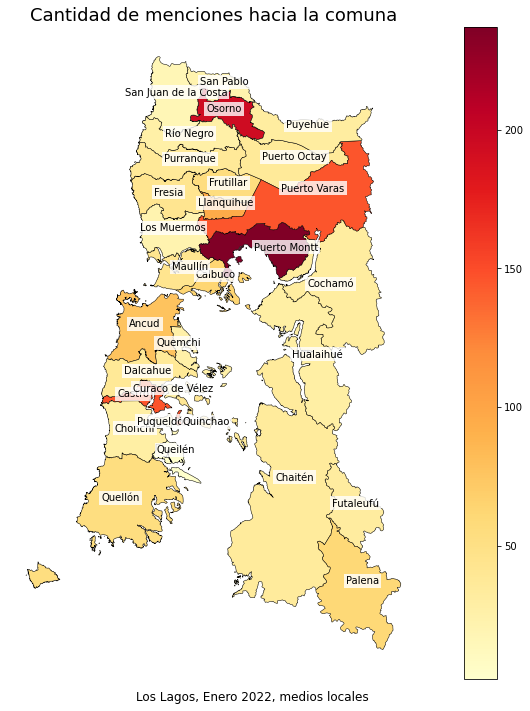

In [81]:
# Graficamos los datos
territory_menciones.plot(column="values", legend=True, figsize=(16, 12), cmap="YlOrRd", edgecolor="black", linewidth=0.5).set_axis_off();
# Información
plt.title("Cantidad de menciones hacia la comuna", fontsize=18);

for idx, row in territory_menciones.iterrows():
    plt.text(row.coords[0], row.coords[1], s=row['Comuna'], horizontalalignment='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

plt.text(0.6, 0.1, "Los Lagos, Enero 2022, medios locales", fontsize=12, ha='center', transform=plt.gcf().transFigure);

### Grafico mapa por topico relevante

In [82]:
# Copia distinta del df
df_topics = df.copy()

In [83]:
def get_moda_list(lista):
    '''
    Parameters:
        lista (list): lista de valores
    Return (int):
        moda1, moda2, porcentaje1'''
    li = lista.copy()
    try: 
        moda = stats.mode(li)
    except:
        return np.NaN, np.NaN, np.NaN

    perc_1 = 0
    while (li.count(moda)):
        perc_1 = perc_1 + 1
        li.remove(moda)
    
    perc_1 = float(perc_1 / len(lista))

    try:
        moda2 = stats.mode(li)
    except:
        return moda, np.NaN, perc_1

    return moda, moda2, perc_1


In [84]:
# --- df_comunas, con topicos principales 1 y 2 ---
# Creamos un df nuevo que contenga como filas los nombres de comunas y com fila [topico_mas_relevante, segundo_topico_mas_relevante]
df_comunas = pd.DataFrame(columns=['topic_1','perc_1','keywords_1' ,'topic_2','keywords_2' , 'total_noticias'], index=comunas)
df_comunas

,topic_1,perc_1,keywords_1,topic_2,keywords_2,total_noticias
Ancud,NaN,NaN,NaN,NaN,NaN,NaN
Calbuco,NaN,NaN,NaN,NaN,NaN,NaN
Castro,NaN,NaN,NaN,NaN,NaN,NaN
Chaitén,NaN,NaN,NaN,NaN,NaN,NaN
Chonchi,NaN,NaN,NaN,NaN,NaN,NaN
Cochamó,NaN,NaN,NaN,NaN,NaN,NaN
Curaco_de_Vélez,NaN,NaN,NaN,NaN,NaN,NaN
Dalcahue,NaN,NaN,NaN,NaN,NaN,NaN
Fresia,NaN,NaN,NaN,NaN,NaN,NaN
Frutillar,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
# --- Calculamos el número de topicos maximos ---
max_topics = df_topics['dominant_Topic'].max()
print(f'Maximo de topicos {max_topics+1}')

# --- Contabilizamos las apariciones de cada comuna ---
for comuna in comunas:
    petitionSQLDF = 'SELECT dominant_Topic, keywords, text, '+comuna+' FROM df_topics WHERE '+comuna+'>0'
    result = sqldf(petitionSQLDF)
    # --- Una vez que hicimos la consulta por comuna ---

    # -- Tomamos los valores de topicos --
    topicos = list(result['dominant_Topic'].values)
    # -- Calculamos la moda_1, moda_2 y porcentaje_1 --
    moda1, moda2, perc_1 = get_moda_list(topicos)

    try:
        # -- Intentamos obtener los keywords de la moda_1 --
        keyword_1 = result[result['dominant_Topic'] == moda1]['keywords'].values[0]
    except:
        keyword_1 = ''

    try:
        # -- Intentamos obtener los keywords de la moda_2 --
        keyword_2 = result[result['dominant_Topic'] == moda2]['keywords'].values[0]
    except:
        keyword_2 = ''
    # print (moda1, perc_1, keyword_1, moda2, keyword_2, len(topicos))
    df_comunas.loc[comuna] = [moda1, perc_1, keyword_1, moda2, keyword_2, len(topicos)+1]

Maximo de topicos 8


In [86]:
df_comunas

,topic_1,perc_1,keywords_1,topic_2,keywords_2,total_noticias
Ancud,4,0.512821,"personas, años, año, comuna, parte, proceso, e...",6,"casos, virus, ingresos, región, drogas, armas,...",79
Calbuco,4,0.444444,"personas, años, año, comuna, parte, proceso, e...",6,"casos, virus, ingresos, región, drogas, armas,...",64
Castro,4,0.564626,"personas, años, año, comuna, parte, proceso, e...",6,"casos, virus, ingresos, región, drogas, armas,...",148
Chaitén,4,0.371429,"personas, años, año, comuna, parte, proceso, e...",6,"casos, virus, ingresos, región, drogas, armas,...",36
Chonchi,6,0.517241,"casos, virus, ingresos, región, drogas, armas,...",4,"personas, años, año, comuna, parte, proceso, e...",30
Cochamó,4,0.5,"personas, años, año, comuna, parte, proceso, e...",6,"casos, virus, ingresos, región, drogas, armas,...",33
Curaco_de_Vélez,4,0.52,"personas, años, año, comuna, parte, proceso, e...",6,"casos, virus, ingresos, región, drogas, armas,...",26
Dalcahue,4,0.578947,"personas, años, año, comuna, parte, proceso, e...",6,"casos, virus, ingresos, región, drogas, armas,...",39
Fresia,4,0.395349,"personas, años, año, comuna, parte, proceso, e...",6,"casos, virus, ingresos, región, drogas, armas,...",44
Frutillar,4,0.381818,"personas, años, año, comuna, parte, proceso, e...",6,"casos, virus, ingresos, región, drogas, armas,...",56


In [87]:
# --- get topic 1 and perc_1 como lista ---
topic_1 = list(df_comunas['topic_1'].values)
topic_2 = list(df_comunas['topic_2'].values)
perc_1 = list(df_comunas['perc_1'].values)

In [88]:
# --- Transformar a INT --- 
# Esta idea se descarto pq daba error al graficar especificando el tipo int
# topic_1 = pd.array(topic_1, dtype=pd.Int64Dtype())
# topic_2 = pd.array(topic_2, dtype=pd.Int64Dtype())

# --- Incluimos los datos de topicos y porcentajes en territory_topicos ---
territory_topicos['topic_1'] = topic_1
territory_topicos['topic_2'] = topic_2
territory_topicos['percentage'] = perc_1

# Colores para cada topico, para maximo 8 topicos
# Por default considerara la posicion como el numero de topico relevante
# es decir, si el topico 0 es el mas relevante, se le asignara el color 0 (#ff6961)
colors_ = ['#ff6961','#ffb480','#f8f38d', '#42d6a4','#08cad1','#59adf6','#9d94ff','#c780e8']

In [89]:
territory_topicos

,Comuna,geometry,coords,topic_1,topic_2,percentage
161,Ancud,"MULTIPOLYGON (((-8254683.395 -5190030.921, -82...","(-8216686.860888084, -5162692.993100001)",4,6.0,0.512821
254,Calbuco,"MULTIPOLYGON (((-8112967.653 -5147692.027, -81...","(-8148106.117221469, -5115110.540750001)",4,6.0,0.444444
167,Castro,"MULTIPOLYGON (((-8171095.068 -5254002.891, -81...","(-8227801.498338105, -5230294.630800001)",4,6.0,0.564626
255,Chaitén,"MULTIPOLYGON (((-8129392.200 -5414186.246, -81...","(-8071710.390358558, -5311626.2905)",4,6.0,0.371429
164,Chonchi,"MULTIPOLYGON (((-8256151.820 -5284821.114, -82...","(-8226395.884103186, -5264155.132449999)",6,4.0,0.517241
148,Cochamó,"MULTIPOLYGON (((-8080034.316 -5118383.675, -80...","(-8036501.702345301, -5124182.419399999)",4,6.0,0.500000
263,Curaco de Vélez,"POLYGON ((-8199043.519 -5219286.418, -8199016....","(-8189567.990258642, -5225226.5592)",4,6.0,0.520000
168,Dalcahue,"MULTIPOLYGON (((-8258700.750 -5225844.867, -82...","(-8214317.499364937, -5207982.5217)",4,6.0,0.578947
51,Fresia,"MULTIPOLYGON (((-8226493.287 -5038106.271, -82...","(-8193670.726446506, -5034990.0834)",4,6.0,0.395349
290,Frutillar,"POLYGON ((-8137646.086 -5009326.261, -8137630....","(-8135714.484708065, -5025736.9432500005)",4,6.0,0.381818


In [90]:
# Creo que no es necesario hacer esto pero por las dudas asignamos color por posicion
color_dict = {i : colors_[i] for i in range(len(colors_))}
print(color_dict)

{0: '#ff6961', 1: '#ffb480', 2: '#f8f38d', 3: '#42d6a4', 4: '#08cad1', 5: '#59adf6', 6: '#9d94ff', 7: '#c780e8'}


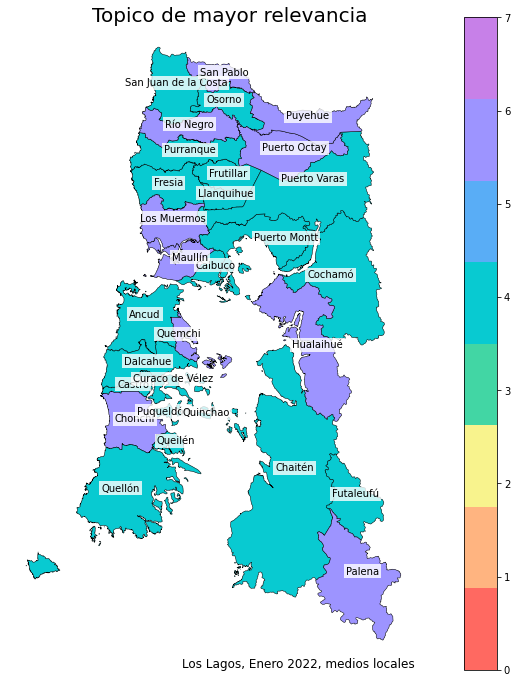

In [91]:
# --- Graficamos topico de mayor relevancia ---
territory_topicos.plot(column="topic_1", cmap=colors.ListedColormap(list(color_dict.values())), legend=True, figsize=(16, 12), edgecolor="black", linewidth=0.5,missing_kwds={
        'color': 'lightgrey',
        'hatch': '///',
        'edgecolor': 'red',
        'label': 'Missing values',
}, vmin=0, vmax=max_topics ).set_axis_off();

# -- Información --
plt.text(0.58, 0.875, 'Topico de mayor relevancia', fontsize=20, ha='center', transform=plt.gcf().transFigure);

for idx, row in territory_topicos.iterrows():
    plt.text(row.coords[0], row.coords[1], s=row['Comuna'], horizontalalignment='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

plt.text(.64, 0.128, "Los Lagos, Enero 2022, medios locales", fontsize=12, ha='center', transform=plt.gcf().transFigure);

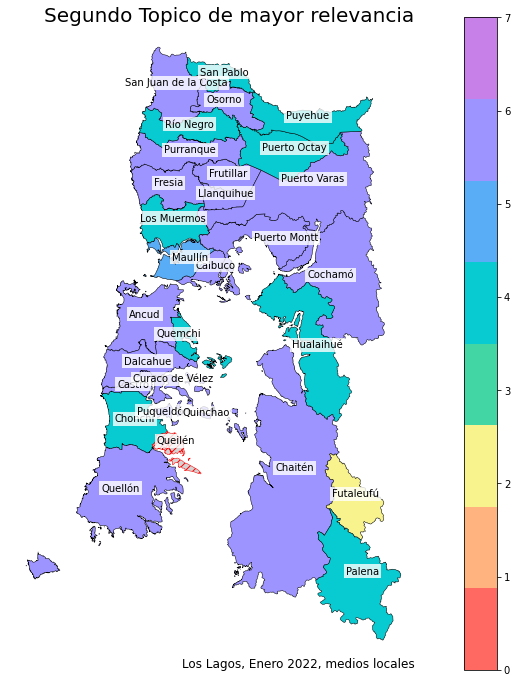

In [132]:
# --- Graficamos segundo topico de mayor relevancia ---
territory_topicos.plot(column="topic_2", cmap=colors.ListedColormap(list(color_dict.values())), legend=True, figsize=(16, 12), edgecolor="black", linewidth=0.5,missing_kwds={
        'color': 'lightgrey',
        'hatch': '///',
        'edgecolor': 'red',
        'label': 'Missing values',
}, vmin=0, vmax=max_topics).set_axis_off();

# -- Información --
plt.text(0.58, 0.875, 'Segundo Topico de mayor relevancia', fontsize=20, ha='center', transform=plt.gcf().transFigure);

for idx, row in territory_topicos.iterrows():
    plt.text(row.coords[0], row.coords[1], s=row['Comuna'], horizontalalignment='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

plt.text(.64, 0.128, "Los Lagos, Enero 2022, medios locales", fontsize=12, ha='center', transform=plt.gcf().transFigure);

### Grafico mapa por positividad

In [93]:
territory_positividad.head(3)

,Comuna,geometry,coords
161,Ancud,"MULTIPOLYGON (((-8254683.395 -5190030.921, -82...","(-8216686.860888084, -5162692.993100001)"
254,Calbuco,"MULTIPOLYGON (((-8112967.653 -5147692.027, -81...","(-8148106.117221469, -5115110.540750001)"
167,Castro,"MULTIPOLYGON (((-8171095.068 -5254002.891, -81...","(-8227801.498338105, -5230294.630800001)"


In [98]:
df.head(2)

,document_No,dominant_Topic,topic_Perc_Contrib,keywords,text,id_news,country,media_outlet,url,title,...,Dalcahue,Curaco_de_Vélez,Cochamó,Chonchi,Chaitén,Castro,Calbuco,Ancud,title_label,title_score
0,0,4,0.9553,"personas, años, año, comuna, parte, proceso, e...",La Fiscalía de Los Lagos dirige una investigac...,21907946.0,chile,radiosago,https://www.radiosago.cl/investigan-muerte-de-...,Investigan muerte de hombre apuñalado en Máfil...,...,0,0,0,0,0,0,0,0,NEU,0.537904
1,1,4,0.9614,"personas, años, año, comuna, parte, proceso, e...",Frente al alza de contagios de Covid-19 en la ...,21908053.0,chile,radiosago,https://www.radiosago.cl/ante-retroceso-a-fase...,Ante retroceso a Fase 3: Municipalidad de Puye...,...,0,0,0,0,0,0,0,0,NEG,0.863434


In [111]:
# --- Creamos df de positividad ---
df_comunas_positividad = pd.DataFrame(columns=['negativo', 'neutro', 'positivo', 'total', 'perc_negativo', 'perc_neutro', 'perc_positivo'], index=comunas)
df_comunas_positividad.head(3)

,negativo,neutro,positivo,total,perc_negativo,perc_neutro,perc_positivo
Ancud,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Calbuco,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Castro,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
# --- Contabilizamos las apariciones de cada comuna ---
for comuna in comunas:
    petitionSQLDF = 'SELECT '+comuna+',title_label, title_score FROM df_topics WHERE '+comuna+'>0'
    result = sqldf(petitionSQLDF)
    # # --- Una vez que hicimos la consulta por comuna ---
    # # -- Tomamos la NEG, NEU y POS de cada noticia --
    neg = []
    neu = []
    pos = []

    for index, row in result.iterrows():
        if row['title_label'] == 'NEG':
            neg.append(row[comuna])
        elif row['title_label'] == 'NEU':
            neu.append(row[comuna])
        elif row['title_label'] == 'POS':
            pos.append(row[comuna])
    
    # --- Agregamos los datos a la tabla ---
    df_comunas_positividad.loc[comuna] = [sum(neg), sum(neu), sum(pos), len(result), sum(neg)/len(result), sum(neu)/len(result), sum(pos)/len(result)]
df_comunas_positividad

,negativo,neutro,positivo,total,perc_negativo,perc_neutro,perc_positivo
Ancud,27,45,6,78,0.346154,0.576923,0.076923
Calbuco,25,34,4,63,0.396825,0.539683,0.063492
Castro,36,83,28,147,0.244898,0.564626,0.190476
Chaitén,8,23,4,35,0.228571,0.657143,0.114286
Chonchi,16,12,1,29,0.551724,0.413793,0.034483
Cochamó,5,26,1,32,0.15625,0.8125,0.03125
Curaco_de_Vélez,9,15,1,25,0.36,0.6,0.04
Dalcahue,19,15,4,38,0.5,0.394737,0.105263
Fresia,20,20,3,43,0.465116,0.465116,0.069767
Frutillar,20,27,8,55,0.363636,0.490909,0.145455


In [114]:
# --- Agregamos los datos de positividad a territory_positividad ---
territory_positividad['negativo'] = list(df_comunas_positividad['negativo'].values)
territory_positividad['neutro'] = list(df_comunas_positividad['neutro'].values)
territory_positividad['positivo'] = list(df_comunas_positividad['positivo'].values)
territory_positividad['total'] = list(df_comunas_positividad['total'].values)
territory_positividad['perc_negativo'] = list(df_comunas_positividad['perc_negativo'].values)
territory_positividad['perc_neutro'] = list(df_comunas_positividad['perc_neutro'].values)
territory_positividad['perc_positivo'] = list(df_comunas_positividad['perc_positivo'].values)
territory_positividad.head(3)


,Comuna,geometry,coords,negativo,neutro,positivo,total,perc_negativo,perc_neutro,perc_positivo
161,Ancud,"MULTIPOLYGON (((-8254683.395 -5190030.921, -82...","(-8216686.860888084, -5162692.993100001)",27,45,6,78,0.346154,0.576923,0.076923
254,Calbuco,"MULTIPOLYGON (((-8112967.653 -5147692.027, -81...","(-8148106.117221469, -5115110.540750001)",25,34,4,63,0.396825,0.539683,0.063492
167,Castro,"MULTIPOLYGON (((-8171095.068 -5254002.891, -81...","(-8227801.498338105, -5230294.630800001)",36,83,28,147,0.244898,0.564626,0.190476


### Grafico mapa por negatividad

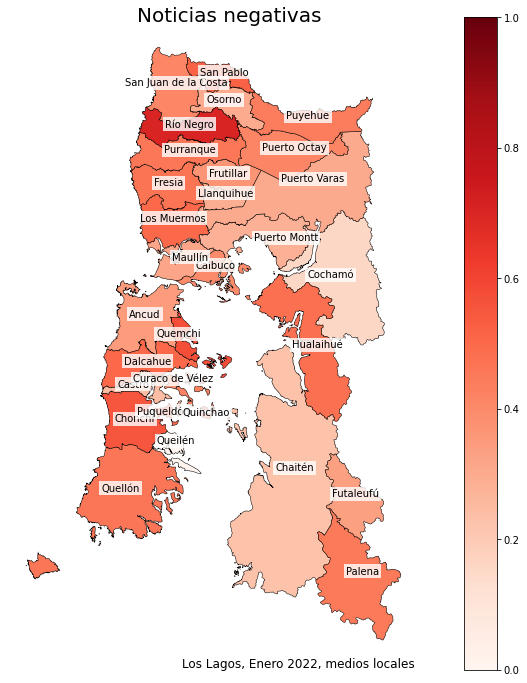

In [123]:
# --- Graficamos por noticias negativas ---
territory_positividad.plot(column="perc_negativo", cmap='Reds', legend=True, figsize=(16, 12), edgecolor="black", linewidth=0.5,missing_kwds={
        'color': 'lightgrey',
        'hatch': '///',
        'edgecolor': 'black',
        'label': 'Missing values',
}, vmin=0, vmax=1).set_axis_off();

# -- Información --
plt.text(0.58, 0.875, 'Noticias negativas', fontsize=20, ha='center', transform=plt.gcf().transFigure);

for idx, row in territory_positividad.iterrows():
    plt.text(row.coords[0], row.coords[1], s=row['Comuna'], horizontalalignment='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

plt.text(.64, 0.128, "Los Lagos, Enero 2022, medios locales", fontsize=12, ha='center', transform=plt.gcf().transFigure);

### Grafico mapa por neutro

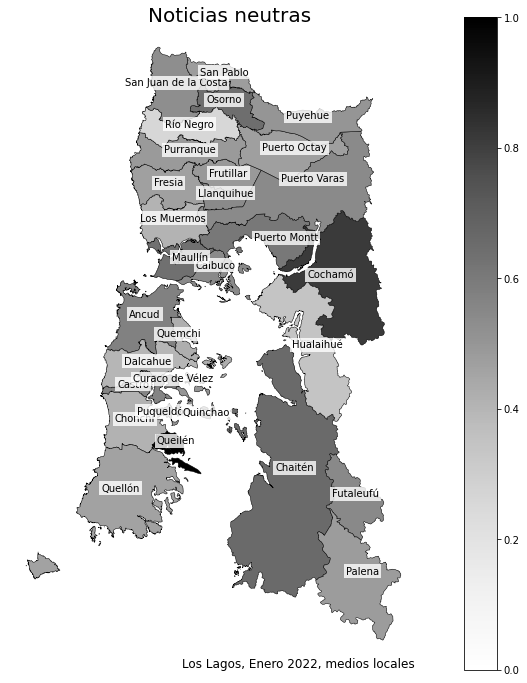

In [124]:
# --- Graficamos por noticias Neutras ---
territory_positividad.plot(column="perc_neutro", cmap='Greys', legend=True, figsize=(16, 12), edgecolor="black", linewidth=0.5,missing_kwds={
        'color': 'lightgrey',
        'hatch': '///',
        'edgecolor': 'black',
        'label': 'Missing values',
}, vmin=0, vmax=1).set_axis_off();

# -- Información --
plt.text(0.58, 0.875, 'Noticias neutras', fontsize=20, ha='center', transform=plt.gcf().transFigure);

for idx, row in territory_topicos.iterrows():
    plt.text(row.coords[0], row.coords[1], s=row['Comuna'], horizontalalignment='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

plt.text(.64, 0.128, "Los Lagos, Enero 2022, medios locales", fontsize=12, ha='center', transform=plt.gcf().transFigure);

### Grafico mapa por positividad

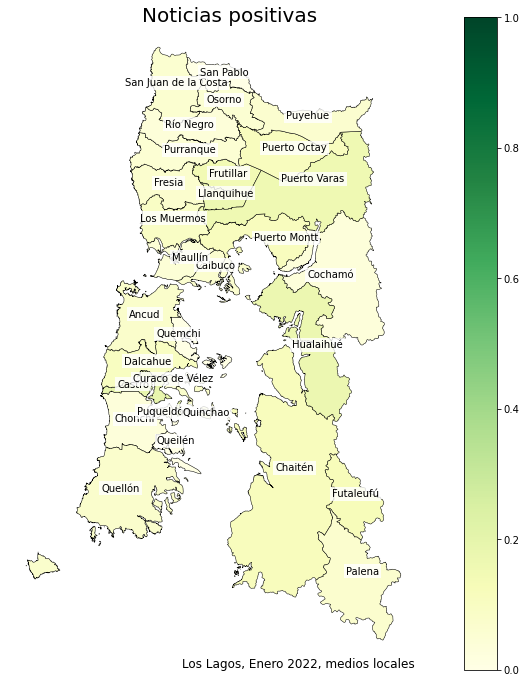

In [131]:
# --- Graficamos por noticias Neutras ---
territory_positividad.plot(column="perc_positivo", cmap='YlGn', legend=True, figsize=(16, 12), edgecolor="black", linewidth=0.5,missing_kwds={
        'color': 'lightgrey',
        'hatch': '///',
        'edgecolor': 'black',
        'label': 'Missing values',
}, vmin=0, vmax=1).set_axis_off();

# -- Información --
plt.text(0.58, 0.875, 'Noticias positivas', fontsize=20, ha='center', transform=plt.gcf().transFigure);

for idx, row in territory_positividad.iterrows():
    plt.text(row.coords[0], row.coords[1], s=row['Comuna'], horizontalalignment='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})
    # plt.text(row.coords[0], row.coords[1]-.5, s=round(row['perc_positivo'],2), horizontalalignment='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

plt.text(.64, 0.128, "Los Lagos, Enero 2022, medios locales", fontsize=12, ha='center', transform=plt.gcf().transFigure);